# Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Organizing the Dataset

In [54]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from itertools import combinations, chain
from torch.utils.data import Dataset, DataLoader, random_split

In [25]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transform=None, pos_ratio=0.619):
        """     
        Args: 
            root_dir (string): Path to diretory with images.
            csv_file (string): Path to csv with all the images.
            transform (callable): Optional transforms to be applied to images.
            pos_ratio (float): Ratio of positive/negative matches present in dataset.
        """
        # Prepare DataFrame with the pair of images
        combined_pos_list = []
        whales_frame = pd.read_csv(csv_file)
        # Series with list of images for each ID
        pos_img_series = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")["Image"]
        # Series of non-matching images
        false_img_series = whales_frame.groupby('Id').agg(lambda x: x.iloc[0])["Image"]
        # Calculates combinations of positive matches
        for idx, v in pos_img_series.iteritems():
            imgs = v.split(",")
            combined = combinations(imgs, 2)
            combined_pos_list.append(combined)
        
        # Positive matches
        positive = pd.DataFrame(list(chain(*combined_pos_list)), columns=["image_1", "image_2"])
        positive["label"] = 1
        
        # Calculates negative matches for all idx
        combined_neg = combinations(false_img_series, 2)
        negative = pd.DataFrame(list(combined_neg), columns=["image_1", "image_2"])
        negative["label"] = 0
        
        
        # Join both frames
        self.data = pd.concat([positive, negative], axis=0, join='outer', ignore_index=True)
        
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # Load images
        img_1_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 0])
        img_2_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 1])
        img_1 = Image.open(img_1_path).convert('RGB')
        img_2 = Image.open(img_2_path).convert('RGB')
        
        
        # Data augmentation
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        # Label for image pair
        label = self.data.iloc[idx, 2]
        
        # Output
        sample = (img_1, img_2, label)
        
        return sample

In [62]:
csv_file = 'humpback-whale-identification/train.csv'
root_dir = 'humpback-whale-identification/train'
# data augmentation
transform = T.Compose([T.ColorJitter(.25, .25, .25,),
                       T.Resize(500),
                       T.RandomRotation(5),
                       T.FiveCrop((320)),
                       T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                      ])
whale_dataset = WhaleDataset(csv_file, root_dir, transform)

In [63]:
data_loader = DataLoader(whale_dataset,
                         batch_size=1,
                         shuffle=True)

In [64]:
len(whale_dataset)

12592447

torch.Size([1, 5, 3, 320, 320])
tensor([0])


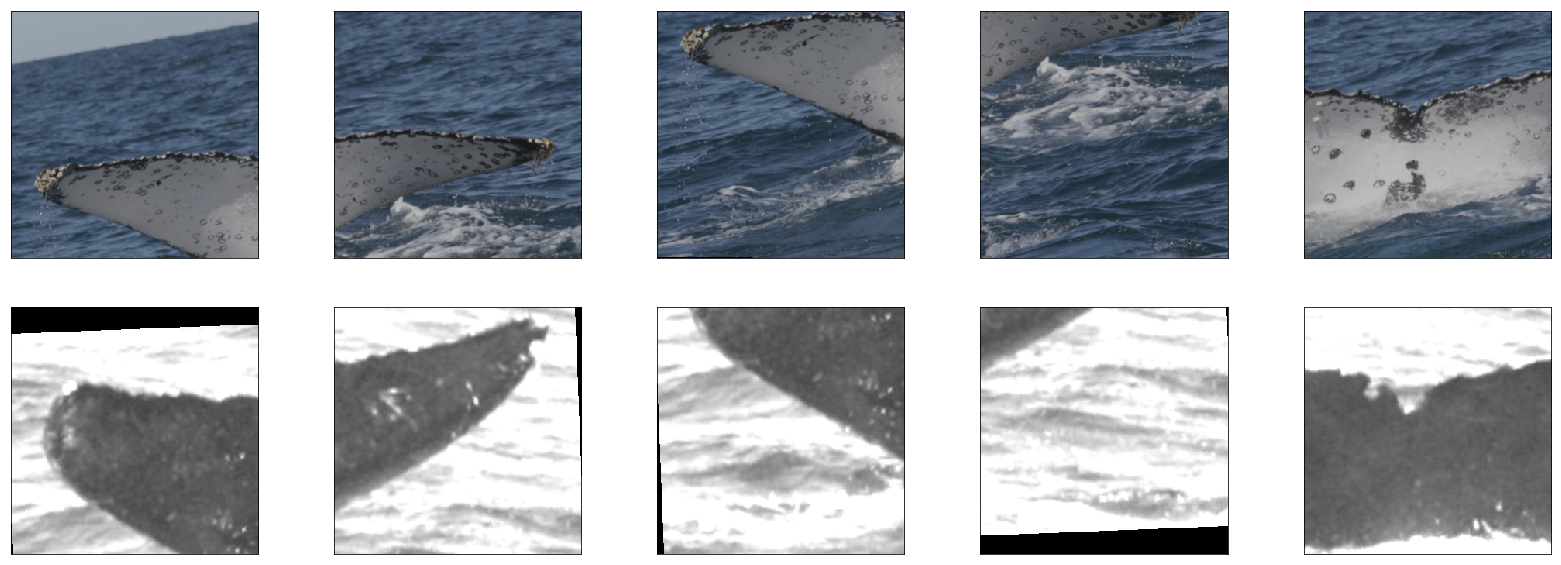

In [65]:
# Check data
img1, img2, label = iter(data_loader).next()

# 5 cropped images
print(img1.size())
bs, ncrops, c, h, w = img1.size()
# 1 item of the batch
imgs_1 = img1[0].numpy()
imgs_2 = img2[0].numpy()
f = plt.figure(figsize=(28, 10))
# For each crop
for idx in range(5):
    ax1 = f.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])
    ax2 = f.add_subplot(2, 5, idx + 6, xticks=[], yticks=[])
    
    ax1.imshow(np.transpose(imgs_1[idx], (1, 2, 0)))
    ax2.imshow(np.transpose(imgs_2[idx], (1, 2, 0)))
print(label)


In [66]:
# Split Data
train_size = int(len(whale_dataset) * .8)
test_size = len(whale_dataset) - train_size
train_dataset, test_dataset = random_split(whale_dataset, [train_size, test_size])

# Dataloader
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True
                         )
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=True
                         )

#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

The model will consist of a feture extrator for the whale pictures.

In [57]:
import torch
from torch import nn
from torch import optim
import torch.functional as F

In [78]:
# Model
class WhaleSimilarity(nn.Module):
    """
    Network defining class.
    """
    def __init__(self):
        super(WhaleSimilarity, self).__init__()
        # Sequence of Convolution + Maxpool Layers
        self.features = nn.Sequential([nn.Conv2d(3, 8, 3, padding=1),  #Convolutional layer (sees 320x320x3 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       nn.Conv2d(8, 16, 3, padding=1),  #Convolutional layer (sees 160x160x8 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       nn.Conv2d(16, 32, 3, padding=1),  #Convolutional layer (sees 80x80x16 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       nn.Conv2d(32, 48, 3, padding=1),  #Convolutional layer (sees 40x40x32 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       nn.Conv2d(48, 64, 3, padding=1),  # Convolutional layer (sees 20x20x48 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       nn.Conv2d(64, 32, 1),  # Convolutional layer (sees 10x10x64 tensor)
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      ])
        # Linear layer with sigmoid
        self.fc = nn.Linear(32 * 5 * 5, 1)
        
    def forward(self, x1, x2):
        # Sequence of convolutional and max pooling layers
        x1 = self.features(x1)
        x2 = self.features(x2)
        
        # Flatten result
        x1 = x1.view(-1, 32 * 5 * 5)
        x2 = x2.view(-1, 32 * 5 * 5)
        
        # Subtrack results
        x = torch.abs(x1 - x2)
        x = nn.sigmoid(self.fc(x))
        
        return x
    

In [ ]:
# Custom Loss
class Regress_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Regress_Loss,self).__init__()
        
    def forward(self,x,y):
        y_shape = y.size()[1]
        x_added_dim = x.unsqueeze(1)
        x_stacked_along_dimension1 = x_added_dim.repeat(1,NUM_WORDS,1)
        diff = torch.sum((y - x_stacked_along_dimension1)**2,2)
        totloss = torch.sum(torch.sum(torch.sum(diff)))
        return totloss

In [75]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [76]:
# Defines Model
model = WhaleSimilarity()

model.to(train_device)

WhaleFeatureExtractor(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=800, out_features=1, bias=True)
)

In [ ]:
# specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

Using transfer learning as features extractors.

In [ ]:
# Load Pretrained Models

resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

alexnet = models.alexnet(pretrained=True)

squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)

inception3 = models.inception_v3(pretrained=True)

In [ ]:
# Add attributes to models
resnet152.name = 'ResNet_152'
resnet152.last_layer_attr = 'fc'

vgg19.name = 'VGG_19'
vgg19.last_layer_attr = 'classifier'

densenet161.name = 'DenseNet_161'
densenet161.last_layer_attr = 'classifier'

# List of Models and its last layer
transfer_models = [resnet152,
                    vgg19,
                    densenet161]